(3659, 6)
(180, 6)


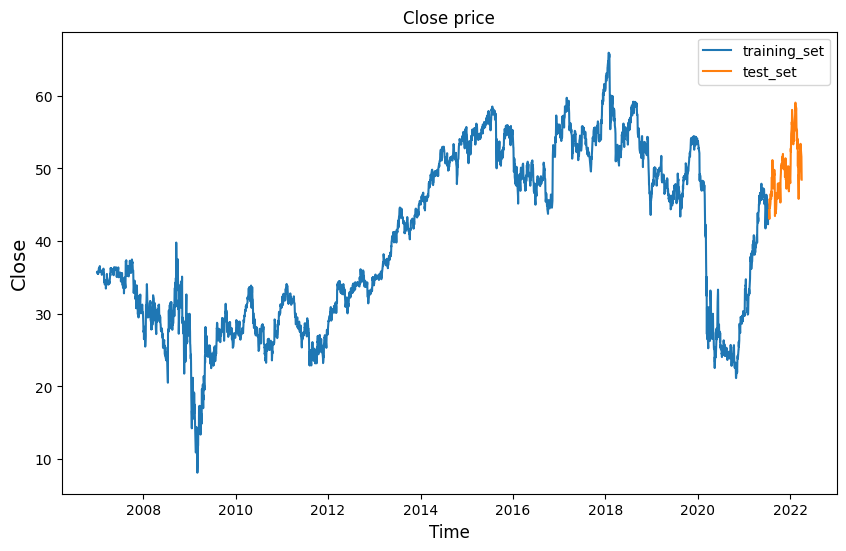

/tmp/ipykernel_775337/4100441635.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_1'] = training_set['Close'].diff(1)


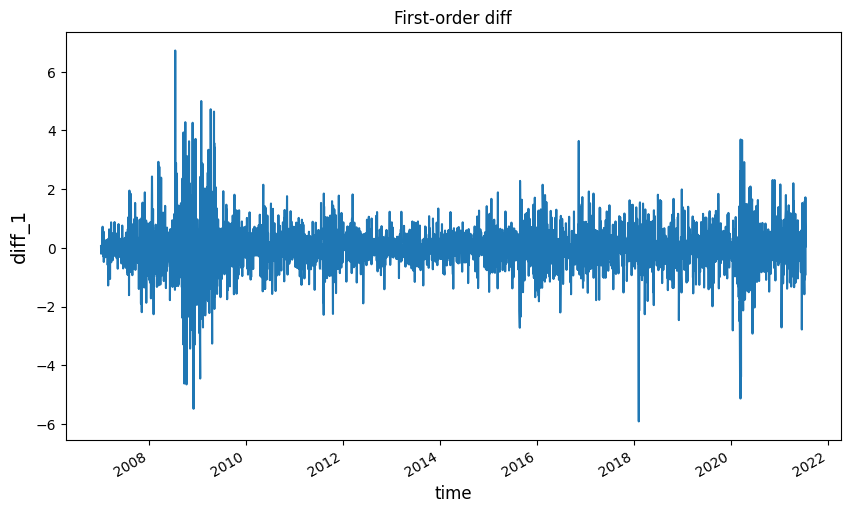

/tmp/ipykernel_775337/4100441635.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_2'] = training_set['diff_1'].diff(1)


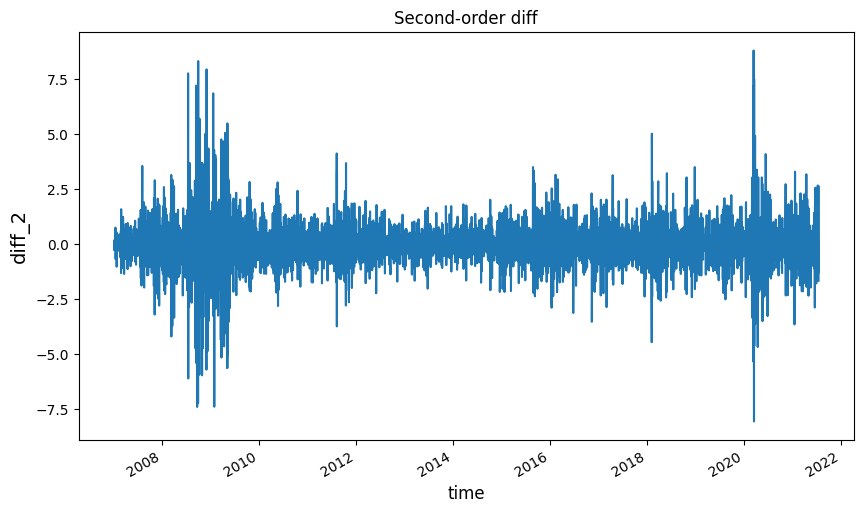

     lb_stat     lb_pvalue    bp_stat     bp_pvalue
1  36.562022  1.478851e-09  36.532053  1.501763e-09
2  40.252449  1.816736e-09  40.218447  1.847886e-09


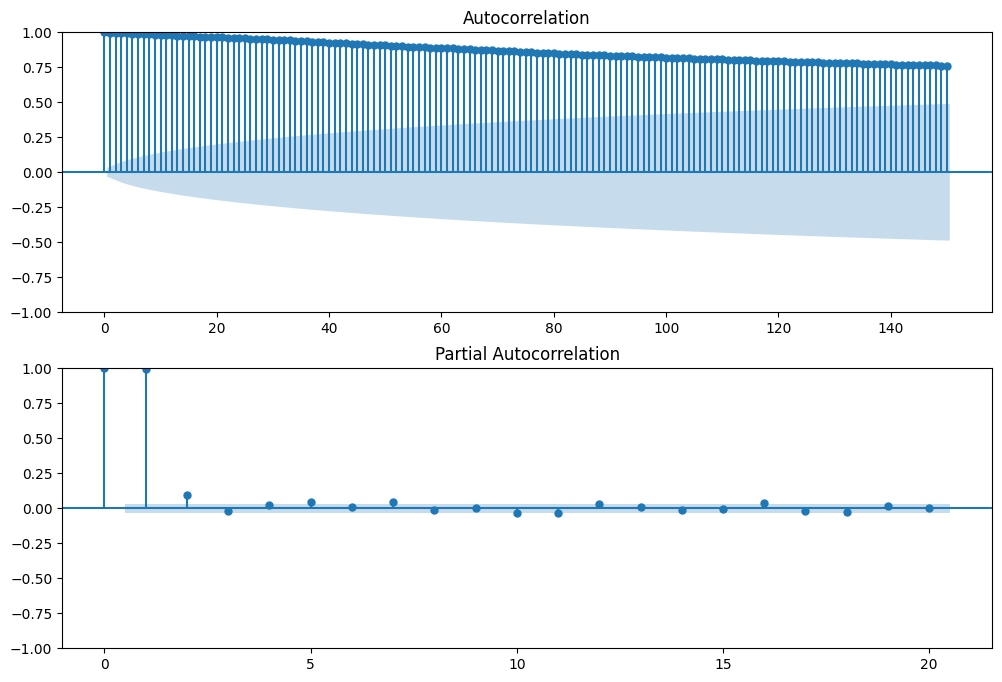

&                Close
Date                
2007-01-04  0.059997
2007-01-05 -0.200001
2007-01-08 -0.099998
2007-01-09  0.090000
2007-01-10 -0.110000
...              ...
2021-07-09  1.590000
2021-07-12  0.250000
2021-07-13 -0.930000
2021-07-14  1.720001
2021-07-15  0.049999

[3658 rows x 1 columns]


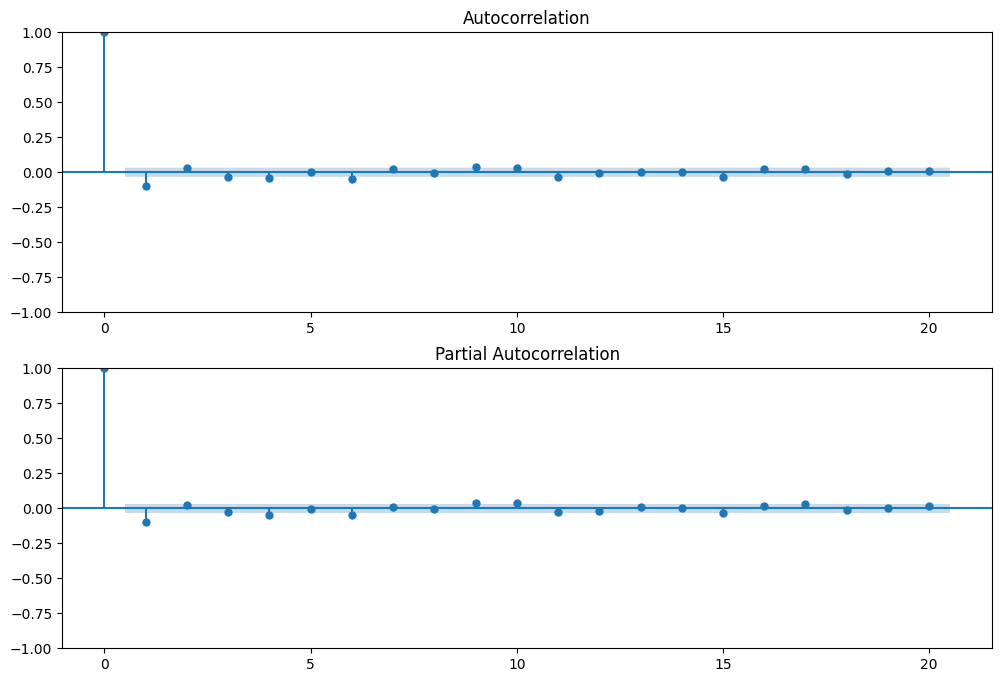

(3, 1, 2)


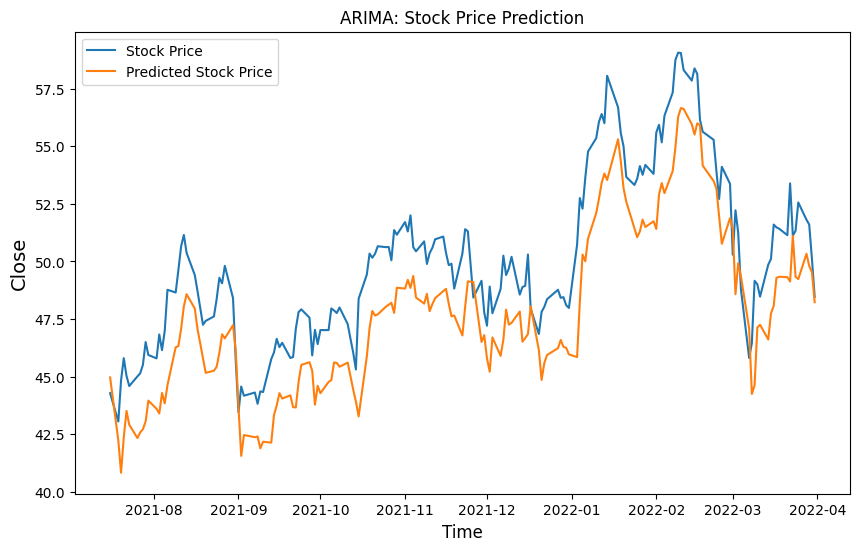

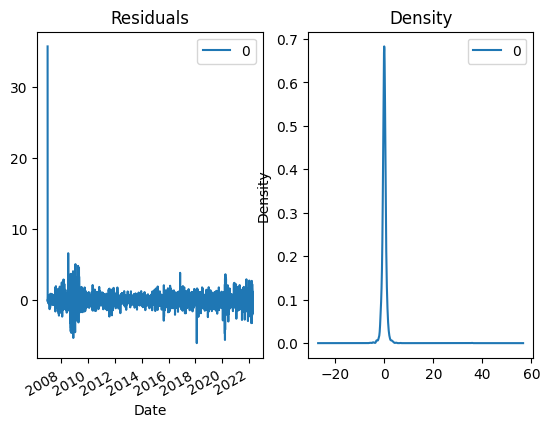

MSE: 6.34752
RMSE: 2.51943
MAE: 2.31370
R2: 0.51576
                                value
Test Statistic Value        -1.761728
p-value                      0.399621
Lags Used                          11
Number of Observations Used      3647
Critical Value(1%)          -3.432144
Critical Value(5%)          -2.862333
Critical Value(10%)         -2.567192
                                 value
Test Statistic Value        -18.558638
p-value                            0.0
Lags Used                           10
Number of Observations Used       3647
Critical Value(1%)           -3.432144
Critical Value(5%)           -2.862333
Critical Value(10%)          -2.567192
# Date
2021-06-15    45.260109
2021-06-16    45.462556
2021-06-17    45.590838
2021-06-18    43.076671
2021-06-21    41.790643
2021-06-22    43.146707
2021-06-23    43.657479
2021-06-24    44.020822
2021-06-25    45.081335
2021-06-28    46.217525
2021-06-29    45.744608
2021-06-30    44.723556
2021-07-01    45.110578
2021-07-02   

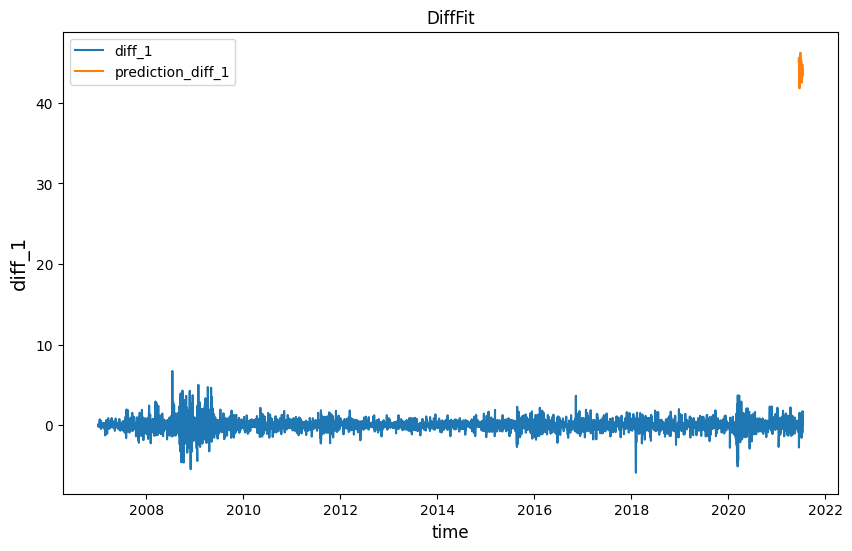

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn import metrics
import statsmodels.api as sm  # acf,pacf plot
from utils import *
#plt.rcParams['font.sans-serif'] = ['SimHei']    # for chinese text on plt
#plt.rcParams['axes.unicode_minus'] = False      # for chinese text negative symbol '-' on plt

data = pd.read_csv('./WFC.csv')
test_set2 = data.loc[3659:, :] 
data.index = pd.to_datetime(data['Date'])
data = data.drop(['Date'], axis=1)
data = pd.DataFrame(data, dtype=np.float64)

training_set = data.loc['2007-01-03':'2021-07-15', :]  # 3642 3501
test_set = data.loc['2021-07-16':, :]  # 196 180

# Show the first few rows of the data
print(training_set.shape)
print(test_set.shape)



plt.figure(figsize=(10, 6))
plt.plot(training_set['Close'], label='training_set')
plt.plot(test_set['Close'], label='test_set')
plt.title('Close price')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

temp = np.array(training_set['Close'])

# First-order diff
training_set['diff_1'] = training_set['Close'].diff(1)
plt.figure(figsize=(10, 6))
training_set['diff_1'].plot()
plt.title('First-order diff')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_1', fontsize=14, horizontalalignment='center')
plt.show()




# Second-order diff
training_set['diff_2'] = training_set['diff_1'].diff(1)
plt.figure(figsize=(10, 6))
training_set['diff_2'].plot()
plt.title('Second-order diff')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_2', fontsize=14, horizontalalignment='center')
plt.show()

temp1 = np.diff(training_set['Close'], n=1)

# white noise test
training_data1 = training_set['Close'].diff(1)
# training_data1_nona = training_data1.dropna()
temp2 = np.diff(training_set['Close'], n=1)
# print(acorr_ljungbox(training_data1_nona, lags=2, boxpierce=True, return_df=True))
print(acorr_ljungbox(temp2, lags=2, boxpierce=True))
# p-value=1.53291527e-08, non-white noise time-seriess


acf_pacf_plot(training_set['Close'],acf_lags=150)

price = list(temp2)
data2 = {
    'Date': training_set['diff_1'].index[1:], 
    'Close': price
}

df = pd.DataFrame(data2)
df['Date'] = pd.to_datetime(df['Date'])

training_data_diff = df.set_index(['Date'], drop=True)
print('&', training_data_diff)

acf_pacf_plot(training_data_diff)

import warnings
warnings.filterwarnings('ignore')  #arima not converging bugs
from pmdarima import auto_arima

mods = auto_arima(training_set['Close'], start_p=0, start_q=0, max_p=8, max_q=3, 
                          test='adf', suppress_warnings=True, stepwise=True)
order_opt = mods.order
print(order_opt)

# order=(p,d,q)
model = sm.tsa.ARIMA(endog=training_set['Close'], order=((3, 1, 2))).fit()
#print(model.summary())

history = [x for x in training_set['Close']]
# print('history', type(history), history)
predictions = list()
# print('test_set.shape', test_set.shape[0])
for t in range(test_set.shape[0]):
    model1 = sm.tsa.ARIMA(history, order=(3, 1, 2))
    model_fit = model1.fit()
    yhat = model_fit.forecast()
    yhat = np.float64(yhat[0])
    predictions.append(yhat)
    obs = test_set2.iloc[t, 5]
    # obs = np.float(obs)
    # print('obs', type(obs))
    history.append(obs)
    # print(test_set.index[t])
    # print(t+1, 'predicted=%f, expected=%f' % (yhat, obs))
#print('predictions', predictions)

predictions1 = {
    'Date': test_set.index[:],
    'Close': predictions
}
predictions1 = pd.DataFrame(predictions1)
predictions1 = predictions1.set_index(['Date'], drop=True)
predictions1.to_csv('./ARIMA.csv')
plt.figure(figsize=(10, 6))
plt.plot(test_set['Close'], label='Stock Price')
plt.plot(predictions1, label='Predicted Stock Price')
plt.title('ARIMA: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

model2 = sm.tsa.ARIMA(endog=data['Close'], order=(3, 1, 2)).fit()
residuals = pd.DataFrame(model2.resid)
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
residuals.to_csv('./ARIMA_residuals1.csv')
evaluation_metric(test_set['Close'],predictions)
adf_test(temp)
adf_test(temp1)

predictions_ARIMA_diff = pd.Series(model.fittedvalues, copy=True)
predictions_ARIMA_diff = predictions_ARIMA_diff[3637:]
print('#', predictions_ARIMA_diff)
plt.figure(figsize=(10, 6))
plt.plot(training_data_diff, label="diff_1")
plt.plot(predictions_ARIMA_diff, label="prediction_diff_1")
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_1', fontsize=14, horizontalalignment='center')
plt.title('DiffFit')
plt.legend()
plt.show()